# Solving a regression problem using gradient descent in PyTorch - Huber loss

The purpose of this notebook is to illustrate how gradient descent works in PyTorch.

Imports:

In [38]:
import numpy as np
from matplotlib import pyplot as plt, animation, rc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

Define the regression function.

In [39]:
def regression_function(alpha,beta,gamma,x): 
    return alpha+beta*x+gamma*x**2

The PyTorch equivalent of the regression function will be called "net".

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

net = Net()

Generate artificial data using the "true" values of the regression parameters.

In [41]:
number_of_observations = 100

alpha_true = 3.0
beta_true = -20.0
gamma_true = 32.0
noise_standard_deviation = 0.25
additional_noise = (4*np.random.binomial(1, 0.03, size=number_of_observations) 
        - 0*np.random.binomial(1, 0.03, size=number_of_observations))
additional_noise_mask = np.where((additional_noise > 0),1,0)

x_data = np.random.random(number_of_observations)
y_data = (regression_function(alpha_true,beta_true,gamma_true,x_data)
        + noise_standard_deviation*np.random.randn(number_of_observations)
        + additional_noise)

x_data_torch = torch.tensor(x_data,dtype=torch.float32).unsqueeze(1)
x_data_squared_torch = torch.tensor(x_data**2,dtype=torch.float32).unsqueeze(1)
x_data_combined_torch = torch.cat((x_data_torch,x_data_squared_torch),1)
y_data_torch = torch.tensor(y_data,dtype=torch.float32).unsqueeze(1)

Plot the generated data. The setup of this figure is later used to create an animation of the optimization process.

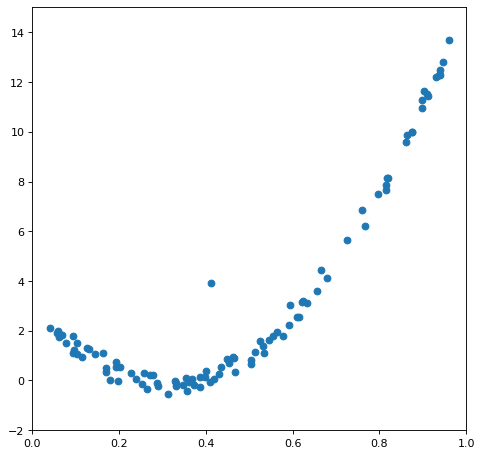

In [42]:
fig = plt.figure(dpi=80,figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_xlim((0,1))
ax.set_ylim((-2,15))
plt.scatter(x_data,y_data)
line_thickness = 2
line, = ax.plot([],[],lw=line_thickness)

Specify an initial guess for the regression parameter value.

In [43]:
alpha_initial_guess = 3.
beta_initial_guess = -2.
gamma_initial_guess = -8.

alpha = alpha_initial_guess
beta = beta_initial_guess
gamma = gamma_initial_guess

with torch.no_grad():
    net.fc1.bias = nn.Parameter(torch.tensor([alpha_initial_guess]))
    net.fc1.weight = nn.Parameter(torch.tensor([[beta_initial_guess,gamma_initial_guess]]))
    
print(net.fc1.bias) 
print(net.fc1.weight)

Parameter containing:
tensor([3.], requires_grad=True)
Parameter containing:
tensor([[-2., -8.]], requires_grad=True)


Choose a learning rate and an animation characteristic.

In [44]:
learning_rate = 0.05
number_of_gradient_descent_steps_per_frame = 100

Specify functions that perform a gradient descent step and functions used for creating an animation of the optimization process.

In [45]:
huber_loss_threshold = 0.6

def gradient_descent_step():
    global alpha, beta, gamma
    y_predicted = regression_function(alpha,beta,gamma,x_data)
    derivative_of_loss_wrt_alpha = np.where(np.abs(y_predicted-y_data)<huber_loss_threshold,
                                           2*(y_predicted-y_data),
                                           2*huber_loss_threshold*np.sign(y_predicted-y_data)).mean()
    derivative_of_loss_wrt_beta = np.where(np.abs(y_predicted-y_data)<huber_loss_threshold,
                                           2*x_data*(y_predicted-y_data),
                                           2*huber_loss_threshold*x_data*np.sign(y_predicted-y_data)).mean()
    derivative_of_loss_wrt_gamma = np.where(np.abs(y_predicted-y_data)<huber_loss_threshold,
                                           2*x_data**2*(y_predicted-y_data),
                                           2*huber_loss_threshold*x_data**2*np.sign(y_predicted-y_data)).mean()
    alpha = alpha - learning_rate*derivative_of_loss_wrt_alpha
    beta = beta - learning_rate*derivative_of_loss_wrt_beta
    gamma = gamma - learning_rate*derivative_of_loss_wrt_gamma
    
optimizer = optim.SGD(net.parameters(), lr=learning_rate)    
    
def gradient_descent_step_torch():
    optimizer.zero_grad()  
    y_predicted_torch = net(x_data_combined_torch)
#     criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss(huber_loss_threshold)
    loss = criterion(y_predicted_torch, y_data_torch)
    loss.backward()
    optimizer.step() 

def frame_evaluation(_):
    x_plotting = np.linspace(0,1,51)
    y_plotting = regression_function(alpha,beta,gamma,x_plotting)
    line.set_data(x_plotting,y_plotting)
    for _ in range(number_of_gradient_descent_steps_per_frame): 
        gradient_descent_step()
    return (line,)
    
def frame_evaluation_torch(_):
    alpha_plotting = net.fc1.bias.data.numpy()[0]
    beta_plotting = net.fc1.weight.data.numpy()[0,0]
    gamma_plotting = net.fc1.weight.data.numpy()[0,1]
    x_plotting = np.linspace(0,1,51)
    y_plotting = regression_function(alpha_plotting,beta_plotting,
                                     gamma_plotting,x_plotting)
    line.set_data(x_plotting,y_plotting)
    for _ in range(number_of_gradient_descent_steps_per_frame): 
        gradient_descent_step_torch()
    return (line,)

Set up the animation.

In [46]:
rc('animation',html='html5')
number_of_frames = 250
frame_interval = 100
resulting_animation = animation.FuncAnimation(
    fig,frame_evaluation,np.arange(0,number_of_frames),interval=frame_interval)
resulting_animation_torch = animation.FuncAnimation(
    fig,frame_evaluation_torch,np.arange(0,number_of_frames),interval=frame_interval)

Set the regression parameter values to the initial guesses. Run the optimization process, capture it as an animation, and display it in the notebook.

In [47]:
resulting_animation

In [48]:
resulting_animation_torch

Save the animation as an mp4 file to the working directory. (Requires resetting the initial values of the parameters.)

In [49]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist=''), bitrate=1800)
resulting_animation.save('resulting_animation.mp4', writer=writer)

Optionally, open the saved animation.

In [51]:
!open 'resulting_animation.mp4'

Couldn't get a file descriptor referring to the console
